# Ground state preparation

Preparing the ground state is a key aspect of simulation. This code emulates one quantum algorithm for doing so: Probabilistic Imaginary Time Evolution (PITE), which controlls forward/reverse Trotter evolution to a single ancilla and performs a weak/mid-circuit measurement on the ancilla to apply a non-unitary operation. See e.g. [our paper](https://arxiv.org/pdf/2202.05864.pdf) and [PITE paper](https://arxiv.org/pdf/2111.12471.pdf), which this notebook is based on.

We will see that while useful for emulating non-unitary operatinos, in practice the stochastic nature of measurements will kill the overall success probability.

In [1]:
import pyquest
pyquest.env

QuESTEnvironment(gpu_accelerated=True, multithreaded=False, distributed=False, num_threads=1, rank=0, num_ranks=1, precision=2)

In [2]:
import numpy as np
from qarsen_lite.singleparticlefunctions import gwp_1D, harmonic_osc_1D

In [3]:
# define spatial grid
L = 15 # box size is 15
n_qubits = 5 # per spatial dimension!

dx = L/(2**n_qubits)
x_grid = np.array([dx*n for n in range(int(2**n_qubits))])

# define wavefunction in 1D
# Initial wavefunction a linear superposition of eigenstates
psi_x = (harmonic_osc_1D(x_grid, n=0, m=1, k=0.1, xc=L/2)/np.sqrt(2) + harmonic_osc_1D(x_grid, n=1, m=1, k=0.1, xc=L/2)/np.sqrt(2))* np.sqrt(dx)


Text(0.5, 0, '$x$')

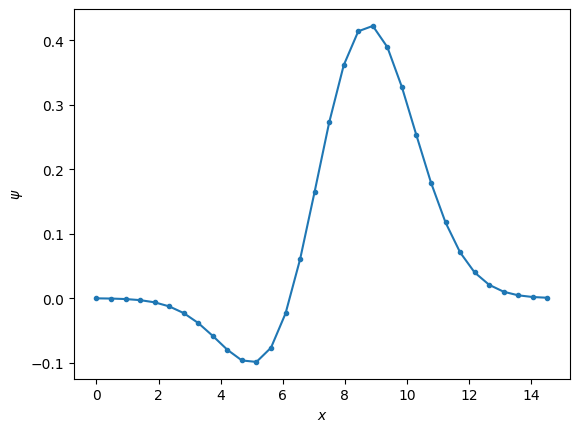

In [4]:
import matplotlib.pyplot as plt

plt.plot(x_grid, psi_x, marker=".")
plt.ylabel("$\psi$")
plt.xlabel("$x$")

In [5]:
# Check normalisation
np.sum(abs(psi_x)**2)

0.9999999191974858

Load into pyquest register

In [6]:
from pyquest import Register

reg_init = Register(n_qubits) # 5 qubits!
reg_init[:] = psi_x

In [7]:
from qarsen_lite.unitaries import gen_QFT_circ, gen_Quadratic_PhaseFunc

def gen_propagators(n_qubits, dx, xc, dt, m, k):
    """
    Specific for 1 particle in 2D harmonic potential, first order trotter - edit as necessary to generalise
    """
    # qubit targets
    init_qbit_idx = 0
    targets = []
    for _ in range(2):
        targets.append(list(range(init_qbit_idx, init_qbit_idx+n_qubits)))
        init_qbit_idx += n_qubits
    
    # QFT circuits
    cQFT_circs = [gen_QFT_circ(targets[d][0], targets[d][-1]) for d in range(1)]
    icQFT_circs = [circ.inverse for circ in cQFT_circs]
    # Kinetic propagator
    dp = 2*np.pi/(2**n_qubits * dx)
    pc = 2**n_qubits * dp / 2 # calculate the centre of the momentum space
    coeff = -dt/(2*m)
    K_props = [gen_Quadratic_PhaseFunc(targets[d], dp, coeff, pc) for d in range(1)]

    # Potential 
    coeff = -k*dt/2
    V_props = [gen_Quadratic_PhaseFunc(targets[d], dx, coeff, xc) for d in range(1)]

    return cQFT_circs, icQFT_circs, K_props, V_props

In [8]:
def apply_single_step(reg, qft_circs, iqft_circs, K_props, V_props, reverse=False):
    """
    """
    if reverse:
        for v in V_props:
            reg.apply_operator(v.inverse)   
            
        for qft in qft_circs:
            reg.apply_circuit(qft)
        for k in K_props:
            reg.apply_operator(k.inverse)
        for iqft in reversed(iqft_circs):
            reg.apply_circuit(iqft)

    else:
        for qft in qft_circs:
            reg.apply_circuit(qft)
        for k in K_props:
            reg.apply_operator(k)
        for iqft in reversed(iqft_circs):
            reg.apply_circuit(iqft)
        
        for v in V_props:
            reg.apply_operator(v)    

Plot the eigenstates

[0.7071067669577065, 0.7071066811433772, 3.4943794780320503e-07, 1.3675285160212602e-06]


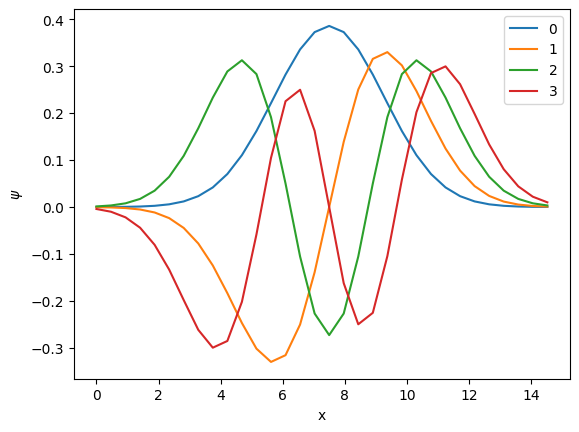

In [11]:
mass = 1
k = 0.1
xc = L/2
eigenstates = [harmonic_osc_1D(x_grid, n, mass, k, xc)* np.sqrt(dx) for n in range(4)]

ov = []
for i, psi in enumerate(eigenstates):
    reg_temp = Register(copy_reg=reg_init)
    reg_temp[:] = psi
    ov.append(abs(reg_temp*reg_init))

    plt.plot(x_grid, psi, label=str(i))

plt.xlabel("x")
plt.ylabel("$\psi$")
plt.legend()
print(ov)

Start with a bit of real time evolution of eigenstates to see what happens

In [13]:
from tqdm import tqdm

def U_RTE(reg_init, dx, t_tot, n_steps, xc, m, k, sample_every=10):
    """
    """
    dt = t_tot/n_steps # time resolution
    reg = Register(copy_reg=reg_init) # copy initial register
    Qft, iQft, K, V = gen_propagators(reg.num_qubits, dx, xc, dt, m, k) # generate propagators

    autocorrelation = []
    print("Running SO-QFT propagation...")
    for n in tqdm(range(n_steps)):
        apply_single_step(reg, Qft, iQft, K, V)

        # saving autocorrelation
        if n%sample_every==0:
            autocorrelation.append(reg*reg_init)
    print("Done!")
    plt.plot(reg.prob_of_all_outcomes(list(range(reg.num_qubits))))

    return autocorrelation

Running SO-QFT propagation...


100%|██████████| 1000/1000 [00:00<00:00, 3448.93it/s]


Done!


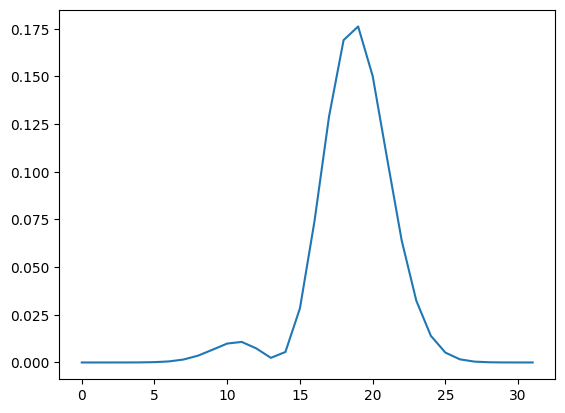

In [14]:
t_tot = 100
n_steps = 1000
sample_every=10
auto = U_RTE(reg_init, dx, t_tot=t_tot, n_steps=n_steps, xc=L/2, m=mass, k=k, sample_every=sample_every)

We see that instead of remaining static/real and imaginary parts precessing as in the case where you only have an eigenstate, the probability density of the particle "vibrates" in the well - exemplified by the autocorrelation.

Text(0, 0.5, '$\\langle\\psi(t)|\\psi(0)\\rangle$')

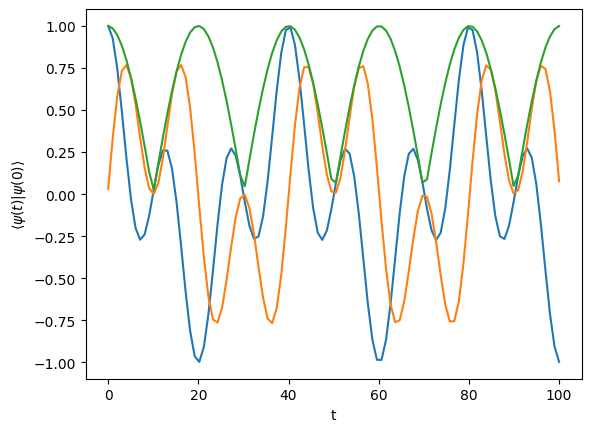

In [16]:
t_grid = np.linspace(0, t_tot, int(n_steps/sample_every))
plt.plot(t_grid, np.real(auto))
plt.plot(t_grid, np.imag(auto))
plt.plot(t_grid, np.abs(auto))
plt.xlabel("t")
plt.ylabel(r"$\langle\psi(t)|\psi(0)\rangle$")

Now we perform (approx) imaginary time evolution

In [17]:
def PITE(reg_init, dx, t_tot, n_steps, xc, m, k, eigenstates, sample_every=10, m0=0.9):
    """
    """
    # time resolution
    dt = t_tot/n_steps 
    reg = Register(copy_reg=reg_init) # copy initial register

    # PITE parameters
    try:
        assert m0!=1/np.sqrt(2) and 0<m0<1
    except AssertionError as err:
        raise err
    kappa = np.sign(m0 - 1/np.sqrt(2))
    th_0 = kappa * np.arccos((m0 + np.sqrt(1-m0**2))/np.sqrt(2)) # angle of Rz gate
    s1 = m0/np.sqrt(1-m0**2) # rescaling factor

    coeff_forward = 0.5 * np.exp(-1j * (np.pi/2 - 2*th_0)/2)
    coeff_reverse = 0.5 * np.exp(1j * (np.pi/2 - 2*th_0)/2)  

    Qft, iQft, K, V = gen_propagators(reg.num_qubits, dx, xc, (dt*s1), m, k) # generate propagators

    
    # PITE loop
    succ_prob = 1
    cumulative_prob = []
    overlap = []

    print("Running SO-QFT propagation...")
    for n in tqdm(range(n_steps)):
        # Execute PITE measurement
        # Copy register and apply backward step
        reg_reverse = Register(copy_reg=reg)
        apply_single_step(reg_reverse, Qft, iQft, K, V, reverse=True)
        # Apply forward step
        apply_single_step(reg, Qft, iQft, K, V)

        reg_temp = coeff_forward*reg + coeff_reverse*reg_reverse

        reg_temp_total_prob = reg_temp.total_prob
        reg = reg_temp * 1/np.sqrt(reg_temp_total_prob)
        # reg_init.copy_from(reg)


        if n%sample_every==0:
            # success probability
            succ_prob *= reg_temp_total_prob
            cumulative_prob.append(succ_prob)
            ov = []
            # eigenstate overlap
            for psi in eigenstates:
                reg_temp = Register(copy_reg=reg_init)
                reg_temp[:] = psi
                ov.append(abs(reg_temp*reg))
            overlap.append(ov)
            
    print("Done!")
    overlap = np.array(overlap).T
    plt.plot(reg.prob_of_all_outcomes(list(range(reg.num_qubits))))

    return overlap, cumulative_prob

Running SO-QFT propagation...


100%|██████████| 1000/1000 [00:03<00:00, 283.65it/s]


Done!


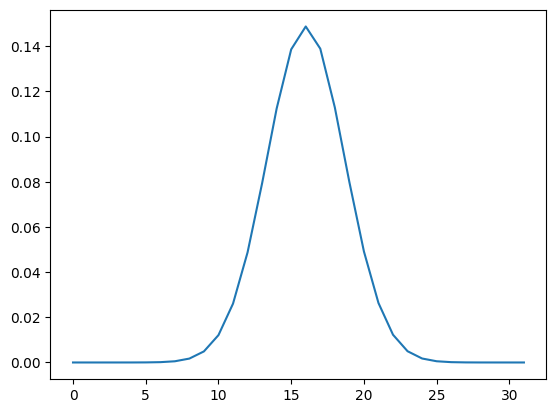

In [18]:
t_tot = 20
n_steps = 1000
sample_every=1
overlap, prob = PITE(reg_init, dx, t_tot=t_tot, n_steps=n_steps, xc=L/2, m=mass, k=k, eigenstates=eigenstates, sample_every=sample_every)

The distribution is that of the ground state. We can see how the overlap goes to unity and the first excited state goes to 0.

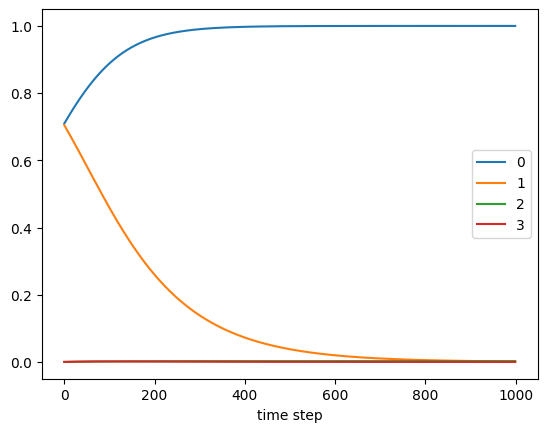

In [22]:
for n, ov in enumerate(overlap):
    plt.plot(ov, label=str(n))

plt.xlabel("time step")
plt.legend()

The practical problem is that the cumulative success probability goes to 0 very early on.

Text(0.5, 0, 'time step')

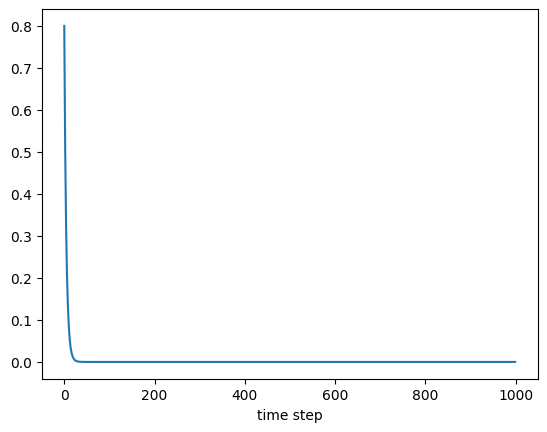

In [23]:
plt.plot(prob)
plt.xlabel("time step")

Depending on the system you are dealing with, the time step resolution needed to ensure convergence is different from real-time evolution. Play around with it and test - plotting the final frame of the particle register tends to help.